In [4]:
import torch
from loguru import logger
from tqdm import tqdm
from omegaconf import OmegaConf
import matplotlib.pyplot as plt

import mdtraj as md
import nglview as nv

from rocketshp import config
from rocketshp.plot import display_trajectory
from rocketshp.datasets.atlas import ATLASDataModule
from rocketshp.modeling.architectures import FlexibilityModelWithTemperature, DynCorrModelWithTemperature

In [5]:
config_file = "../configs/default_config.yml"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split/model-epoch=14-train_loss=0.01.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split_CA_loss/model-epoch=02-train_loss=2.68.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split_CA_loss/model-epoch=07-train_loss=2.66.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/foldseek_0.2_split_sqformer/model-epoch=15-train_loss=13.01.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/new_unstack_before_loss/model-epoch=02-train_loss=0.83.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/new_unstack_before_loss.2/model-epoch=17-train_loss=0.28.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/revert_loss/model-epoch=17-train_loss=0.29.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/retesting_old/model-epoch=02-train_loss=0.69.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/temperature_atlas/model-epoch=10-train_loss=0.36.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/cadist_alpha1_dyncorr_alpha3/model-epoch=05-train_loss=1.03.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/cadist_alpha1_dyncorr_alpha5/model-epoch=05-train_loss=1.00.pt.ckpt"
# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/grad_norm_alpha0.12_lr1e-5/model-epoch=19-train_loss=0.55.pt.ckpt"
checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/models/seq_feats_only/model-epoch=18-train_loss=0.29.pt.ckpt"

# checkpoint_file = "/mnt/home/ssledzieski/Projects/rocketshp/checkpoints/mdcath_temp_2/model-epoch=16-train_loss=0.30.pt.ckpt"

PARAMS = config.DEFAULT_PARAMETERS
PARAMS.update(OmegaConf.load(config_file))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [6]:
adl = ATLASDataModule(config.PROCESSED_DATA_DIR / "atlas/atlas_processed.h5",
                      seq_features=True, struct_features=True,
                      batch_size=8, num_workers=PARAMS.num_data_workers,
                      train_pct=PARAMS.train_pct, val_pct=PARAMS.val_pct,
                      random_seed=PARAMS.random_seed,
                      )
adl.setup("train")
ads = adl.dataset
logger.info(f"{len(adl.dataset)}, {len(adl.train_data)}, {len(adl.val_data)}, {len(adl.test_data)}")

2025-02-06 06:00:40.809 | INFO     | __main__:<module>:9 - 4167, 3360, 396, 411


In [7]:
# model = FlexibilityModelWithTemperature.load_from_checkpoint(checkpoint_file, strict=True)
# model = FlexibilityModel.load_from_checkpoint(checkpoint_file, strict=False)
model = DynCorrModelWithTemperature.load_from_checkpoint(checkpoint_file, strict=True)
model = model.to(device)

/mnt/home/ssledzieski/Projects/rocketshp/rocketshp/modeling/architectures.py:409: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  chk = torch.load(checkpoint_path)


In [9]:
def get_idx_name(name):
    return adl.dataset.samples.index(name)

2025-02-06 06:05:20.499 | INFO     | __main__:<module>:40 - Protein: 1dci_C/R1
2025-02-06 06:05:20.501 | INFO     | __main__:<module>:41 - Spearman: SignificanceResult(statistic=0.7966896511929835, pvalue=1.203956957209311e-61)
2025-02-06 06:05:20.502 | INFO     | __main__:<module>:42 - Pearson: PearsonRResult(statistic=0.87323713, pvalue=3.2297220936623374e-87)
2025-02-06 06:05:20.503 | INFO     | __main__:<module>:43 - MSE: 0.004660697188228369


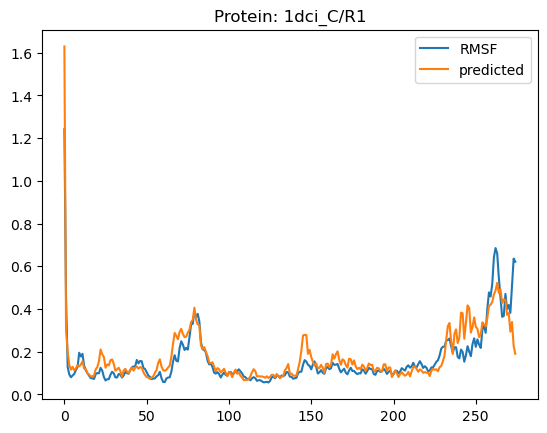

In [18]:
### by key ###
# key = "1a62_A/R1"
# feats, labels = adl.dataset[get_idx_name("1a62_A/R1")]
##############

### by index ###
DATA_SUBSET = adl.test_data
# DATA_SUBSET = adl.val_data
# DATA_SUBSET = adl.train_data

# SAMPLE_I = 100 # test
# SAMPLE_I = 84 # test
SAMPLE_I = 15 # test
# SAMPLE_I = 300 # validation
# SAMPLE_I = 192 # validation

feats, labels = DATA_SUBSET[SAMPLE_I]
key = adl.dataset.samples[DATA_SUBSET.indices[SAMPLE_I]]
##############

def normalize(x):
    return (x - x.mean()) / x.std()

with torch.no_grad():
        both_result = model({k: v.to(device).unsqueeze(0) for k, v in feats.items()})
        feats["struct_feats"] = torch.zeros_like(feats["struct_feats"])
        seqonly_result = model({k: v.to(device).unsqueeze(0) for k, v in feats.items()})

plt.plot(labels["rmsf"],label="RMSF")
plt.plot(both_result["rmsf"].detach().cpu().numpy().squeeze(),label="predicted")
# plt.plot(seqonly_result["rmsf"].detach().cpu().numpy().squeeze(),label="predicted seq only")
plt.title(f"Protein: {key}")
plt.legend()


from scipy.stats import spearmanr, pearsonr
spearman = spearmanr(labels["rmsf"], both_result["rmsf"].detach().cpu().numpy().squeeze())
pearson = pearsonr(labels["rmsf"], both_result["rmsf"].detach().cpu().numpy().squeeze())
mse = ((labels["rmsf"] - both_result["rmsf"].detach().cpu().numpy().squeeze())**2).mean()
logger.info(f"Protein: {key}")
logger.info(f"Spearman: {spearman}")
logger.info(f"Pearson: {pearson}")
logger.info(f"MSE: {mse}")

plt.show()

In [19]:
pdb_code, rep = key.split("/")
print(config.RAW_DATA_DIR  / f"atlas/{pdb_code[:2]}/{pdb_code}_prod_{rep}_fit.xtc",config.RAW_DATA_DIR  / f"atlas/{pdb_code[:2]}/{pdb_code}.pdb")
traj = md.load_xtc(config.RAW_DATA_DIR  / f"atlas/{pdb_code[:2]}/{pdb_code}_prod_{rep}_fit.xtc", top=config.RAW_DATA_DIR  / f"atlas/{pdb_code[:2]}/{pdb_code}.pdb")
view = display_trajectory(traj, bfactor=both_result["rmsf"].detach().cpu().numpy().squeeze(), coloring="bfactor", normalize=True, RMAX=0.3)
# view = display_trajectory(traj[::10], bfactor=labels["rmsf"].squeeze(), coloring="bfactor", normalize=True, RMAX=0.3)
# view = display_trajectory(traj[::100], coloring="residueindex")
view

/mnt/home/ssledzieski/Projects/rocketshp/data/raw/atlas/1d/1dci_C_prod_R1_fit.xtc /mnt/home/ssledzieski/Projects/rocketshp/data/raw/atlas/1d/1dci_C.pdb


NGLWidget(max_frame=10000)

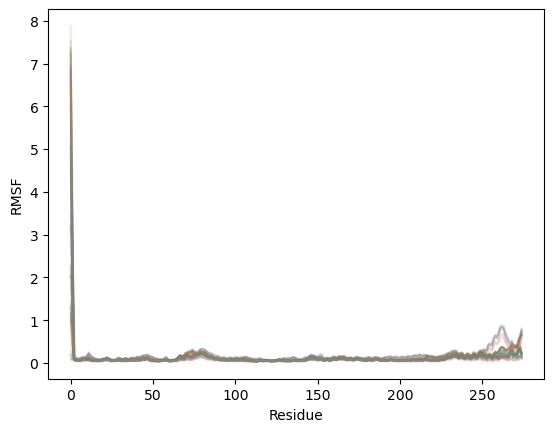

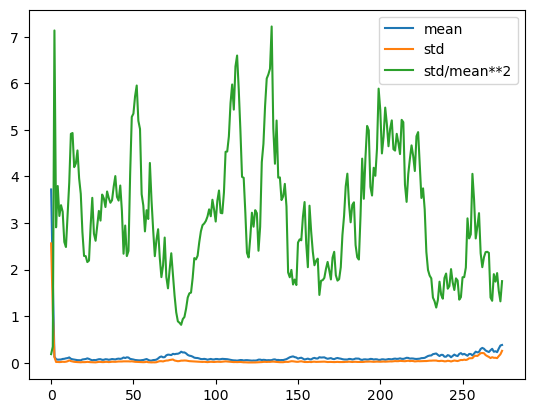

In [20]:
import numpy as np

subsample_rmsf = []
for _ in range(50):
    start = np.random.randint(0, traj.n_frames//2)
    duration = np.random.randint(1, traj.n_frames//2 - start)
    stride = 1
    t_sub = traj[start:start+duration:stride]
    sample = md.rmsf(t_sub, t_sub, 0, atom_indices=traj.top.select("name CA"))
    subsample_rmsf.append(sample)

subsample_rmsf = np.stack(subsample_rmsf)
import matplotlib.pyplot as plt

plt.plot(np.arange(subsample_rmsf.shape[1]), subsample_rmsf.T, alpha=0.2)
plt.xlabel("Residue")
plt.ylabel("RMSF")
plt.show()

plt.plot(np.arange(subsample_rmsf.shape[1]), subsample_rmsf.mean(axis=0),label="mean")
plt.plot(np.arange(subsample_rmsf.shape[1]), subsample_rmsf.std(axis=0),label="std")
plt.plot(np.arange(subsample_rmsf.shape[1]), subsample_rmsf.std(axis=0) / subsample_rmsf.mean(axis=0)**2, label="std/mean**2")

plt.legend()
plt.show()

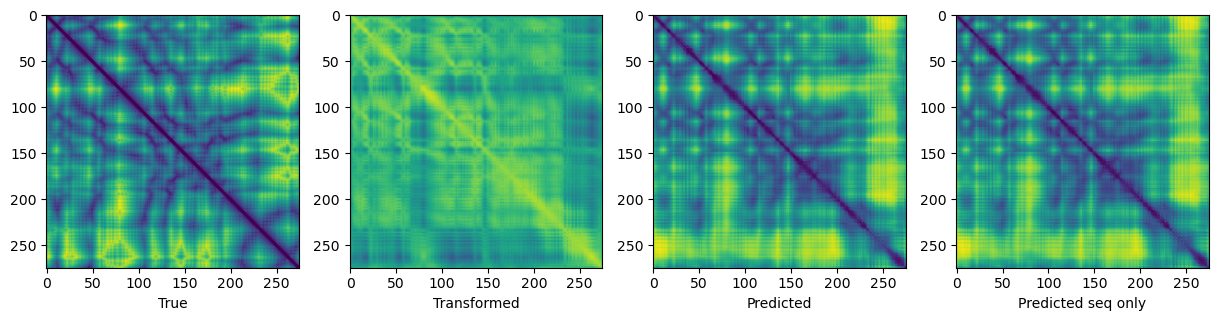

In [21]:
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
true_sqform = labels["ca_dist"].squeeze()
# transform_sqform = model._cross_transform((feats["seq_feats"].unsqueeze(0), feats["struct_feats"].unsqueeze(0))).squeeze().detach().cpu().numpy()
transform_sqform = model._cross_transform({k: v.unsqueeze(0).to(device) for k,v in feats.items()}).squeeze().detach().cpu().numpy()


ax[0].imshow(true_sqform.squeeze())
ax[0].set_xlabel("True")
ax[1].imshow(transform_sqform)
ax[1].set_xlabel("Transformed")
ax[2].imshow(both_result["ca_dist"].cpu().squeeze())
ax[2].set_xlabel("Predicted")
ax[3].imshow(seqonly_result["ca_dist"].cpu().squeeze())
ax[3].set_xlabel("Predicted seq only")
# plt.suptitle("Contacts")
plt.show()

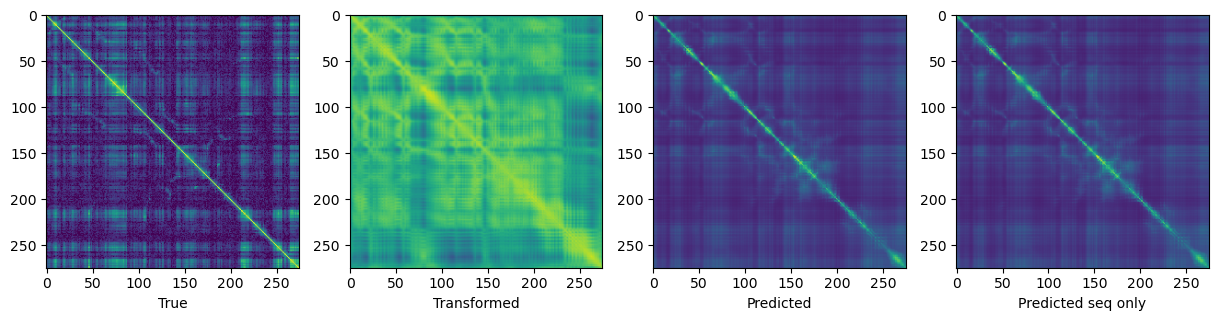

In [22]:
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
true_sqform = labels["dyn_corr"].squeeze()
transform_sqform = model._cross_transform({k: v.unsqueeze(0).to(device) for k,v in feats.items()}).squeeze().detach().cpu().numpy()


ax[0].imshow(true_sqform.squeeze(), vmin=0, vmax=1)
ax[0].set_xlabel("True")
ax[1].imshow(transform_sqform)
ax[1].set_xlabel("Transformed")
ax[2].imshow(both_result["dyn_corr"].cpu().squeeze(), vmin=0, vmax=1)
ax[2].set_xlabel("Predicted")
ax[3].imshow(seqonly_result["dyn_corr"].cpu().squeeze(), vmin=0, vmax=1)
ax[3].set_xlabel("Predicted seq only")
plt.show()

In [97]:
import numpy as np
from scipy.spatial.distance import squareform, pdist
from sklearn.manifold import MDS
import warnings

def distance_matrix_to_structure(distance_matrix, max_iter=1000, n_init=4):
    """
    Convert a distance matrix of Calpha positions into 3D coordinates.
    
    Parameters:
    -----------
    distance_matrix : numpy.ndarray
        Square matrix of pairwise distances between Calpha atoms
    max_iter : int, optional
        Maximum number of iterations for MDS optimization
    n_init : int, optional
        Number of times to run MDS with different random seeds
        
    Returns:
    --------
    coordinates : numpy.ndarray
        Nx3 array of predicted 3D coordinates for each Calpha
    stress : float
        Final stress value indicating quality of the embedding
    """
    # Input validation
    if not isinstance(distance_matrix, np.ndarray):
        distance_matrix = np.array(distance_matrix)
    
    if distance_matrix.shape[0] != distance_matrix.shape[1]:
        raise ValueError("Distance matrix must be square")
        
    # Ensure matrix is symmetric
    distance_matrix = (distance_matrix + distance_matrix.T) / 2
    
    # Create MDS object
    mds = MDS(n_components=3,
              metric=True,
              max_iter=max_iter,
              n_init=n_init,
              dissimilarity='precomputed',
              normalized_stress='auto')
    
    # Suppress convergence warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        
        # Convert distance matrix to 3D coordinates
        try:
            coords = mds.fit_transform(distance_matrix)
            stress = mds.stress_
        except Exception as e:
            raise RuntimeError(f"MDS failed to converge: {str(e)}")
    
    return coords, stress

def save_to_pdb(coordinates, filename, resid, chain_id='A'):
    """
    Save the predicted coordinates to a PDB file format.
    
    Parameters:
    -----------
    coordinates : numpy.ndarray
        Nx3 array of 3D coordinates
    filename : str
        Output PDB filename
    chain_id : str, optional
        Chain identifier for the PDB file
    """
    with open(filename, 'w') as f:
        f.write("TITLE     Predicted structure from distance matrix\n")
        for i, (coord, rid) in enumerate(zip(coordinates, resid)):
            x, y, z = coord
            # Standard PDB ATOM record format
            atom_line = (f"ATOM  {i+1:5d}  CA  {rid} {chain_id}{i+1:4d}"
                        f"    {x:8.3f}{y:8.3f}{z:8.3f}"
                        f"  1.00  0.00           C  \n")
            f.write(atom_line)
        f.write("END\n")

def assess_structure_quality(distance_matrix, predicted_coords):
    """
    Assess the quality of the predicted structure by comparing
    the input and reconstructed distance matrices.
    
    Parameters:
    -----------
    distance_matrix : numpy.ndarray
        Original input distance matrix
    predicted_coords : numpy.ndarray
        Predicted 3D coordinates
        
    Returns:
    --------
    rmsd : float
        Root mean square deviation between original and 
        reconstructed distances
    max_error : float
        Maximum error in any pairwise distance
    """
    # Calculate pairwise distances from predicted coordinates
    predicted_distances = squareform(pdist(predicted_coords))
    
    # Calculate errors
    errors = np.abs(distance_matrix - predicted_distances)
    rmsd = np.sqrt(np.mean(errors**2))
    max_error = np.max(errors)
    
    return rmsd, max_error

In [45]:
# Example distance matrix (you would replace this with your actual data)
n_residues = 10
# example_distances = np.random.uniform(3.8, 15.0, size=(n_residues, n_residues))
# example_distances = (example_distances + example_distances.T) / 2
# np.fill_diagonal(example_distances, 0)

# Convert to 3D coordinates
coords, stress = distance_matrix_to_structure(both_result["dyn_corr"].squeeze().numpy())

# Assess quality
# rmsd, max_error = assess_structure_quality(true_sqform.squeeze(), coords)

# print(f"Structure generated with stress: {stress:.4f}")
# print(f"RMSD from original distances: {rmsd:.4f} Å")
# print(f"Maximum pairwise distance error: {max_error:.4f} Å")

# Save to PDB file
save_to_pdb(coords, "predicted_structure.pdb", ["ALA"] * n_residues)

In [51]:
coords.shape

(183, 3)

In [53]:
adl.dataset._handle[key]["xyz"][:][0]

array([[ 2.0129595 ,  0.25868416,  2.0152874 ],
       [ 2.0029597 ,  0.21888423,  2.1108875 ],
       [ 1.9979596 ,  0.18248415,  1.9460874 ],
       ...,
       [-1.4010403 , -3.0623157 ,  0.33728743],
       [-1.3210402 , -3.1163158 ,  0.41828752],
       [-1.4220402 , -3.1123157 ,  0.22728753]], dtype=float32)

## Batch

In [8]:
fb, yb, lb = next(iter(adl.train_dataloader()))

In [10]:
predb = model(fb)

In [15]:
from rocketshp.datasets.data_utils import _unstack_variable_length_tensors

In [16]:
def _unstack_variable_size_squareforms(stacked, lengths):
        
    return [stacked[i, :sl, :sl] for i, sl in enumerate(lengths)]

In [17]:
tt = _unstack_variable_length_tensors(predb["rmsf"], lb)
sf = _unstack_variable_size_squareforms(predb["ca_dist"], lb)
tsf = _unstack_variable_size_squareforms(yb["ca_dist"], lb)

In [18]:
predb["ca_dist"].shape,yb["ca_dist"].shape,predb["rmsf"].shape,yb["rmsf"].shape

(torch.Size([8, 415, 415]),
 torch.Size([8, 415, 415]),
 torch.Size([8, 415, 1]),
 torch.Size([8, 415]))

In [ ]:
# from rocketshp.modeling.pt_lightning import compute_square_masked_mse_loss, compute_masked_mse_loss
# compute_masked_mse_loss(predb["rmsf"], yb["rmsf"].unsqueeze(-1), lb, rmse=True),compute_square_masked_mse_loss(predb["ca_dist"], yb["ca_dist"], lb, rmse=True)
import torch.nn as nn

outputs = predb["ca_dist"]
labels = yb["ca_dist"]
lengths = lb

rmse=False
pad_value=0.0

linmask = (torch.arange(outputs.shape[1], device=outputs.device)[None, :] < lengths[:, None])
squaremask = (linmask.unsqueeze(2) & linmask.unsqueeze(1))

# Use built-in MSELoss with reduction='none' to get per-element loss
mse_loss = nn.MSELoss(reduction='none')
init_loss = mse_loss(outputs, labels)

# Apply mask and compute mean over valid elements
masked_loss = init_loss * squaremask
mse = masked_loss.sum() / squaremask.sum()
print(mse)
print(masked_loss.sum(axis=(1,2)) / squaremask.sum(axis=(1,2)))
print()

# loss = torch.sqrt(mse) if rmse else mse
# print(loss)

tensor(0.1816, grad_fn=<DivBackward0>)
tensor([0.0730, 0.0730, 0.0730, 0.6660, 0.6660, 0.6660, 0.6465, 0.6465],
       grad_fn=<DivBackward0>)
tensor(0.4388, grad_fn=<MeanBackward0>)


In [39]:
ca_dist_pred_unstacked = _unstack_variable_size_squareforms(outputs, lengths)
ca_dist_true_unstacked = _unstack_variable_size_squareforms(labels, lengths)

reduce_loss = nn.MSELoss()
ca_dist_loss = []
for pred, true in zip(ca_dist_pred_unstacked, ca_dist_true_unstacked):
    ca_dist_loss.append(reduce_loss(pred, true))
# loss = torch.sqrt(ca_dist_loss) if rmse else ca_dist_loss
# print(loss)
print(torch.stack(ca_dist_loss))

tensor([0.0730, 0.0730, 0.0730, 0.6660, 0.6660, 0.6660, 0.6465, 0.6465],
       grad_fn=<StackBackward0>)


In [61]:
def compute_square_masked_mse_loss(outputs, labels, lengths, rmse=False, pad_value=0.0):
    linmask = (torch.arange(outputs.shape[1], device=outputs.device)[None, :] < lengths[:, None])
    squaremask = (linmask.unsqueeze(2) & linmask.unsqueeze(1))
    
    # Use built-in MSELoss with reduction='none' to get per-element loss
    mse_loss = nn.MSELoss(reduction='none')
    loss = mse_loss(outputs, labels)

    # Apply mask and compute mean over valid elements
    masked_loss = loss * squaremask
    # mse = masked_loss.sum() / squaremask.sum().clamp(min=1)
    mse = (masked_loss.sum(axis=(1,2)) / squaremask.sum(axis=(1,2))).mean()

    return torch.sqrt(mse) if rmse else mse

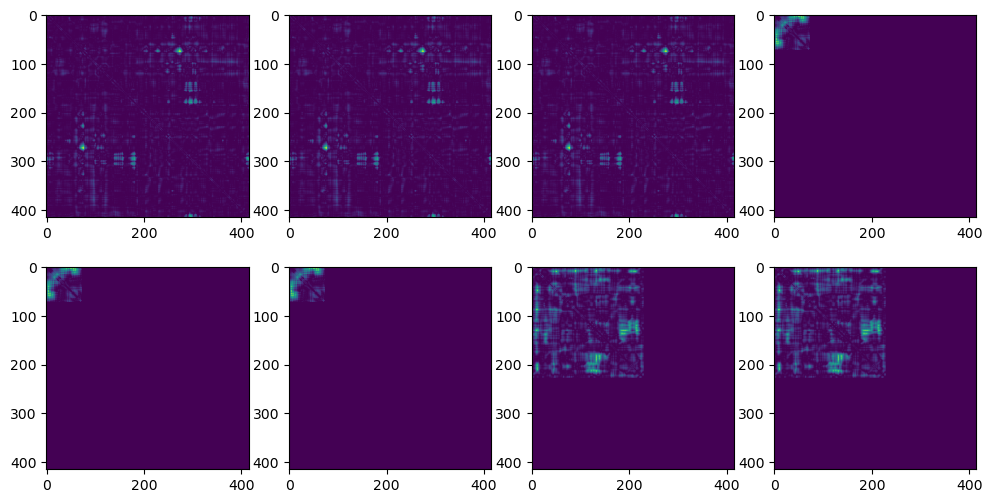

In [26]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(2, 4, figsize=(12, 6))

ax[0, 0].imshow(masked_loss[0].detach().cpu().numpy())
ax[0, 1].imshow(masked_loss[1].detach().cpu().numpy())
ax[0, 2].imshow(masked_loss[2].detach().cpu().numpy())
ax[0, 3].imshow(masked_loss[3].detach().cpu().numpy())
ax[1, 0].imshow(masked_loss[4].detach().cpu().numpy())
ax[1, 1].imshow(masked_loss[5].detach().cpu().numpy())
ax[1, 2].imshow(masked_loss[6].detach().cpu().numpy())
ax[1, 3].imshow(masked_loss[7].detach().cpu().numpy())
plt.show()

tensor(3.1176, grad_fn=<SqrtBackward0>)

In [19]:
x = model._transform((fb["seq_feats"], fb["struct_feats"]))

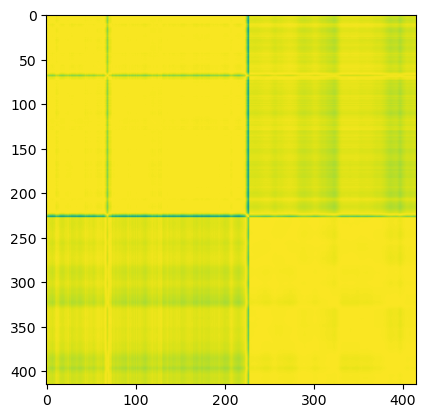

In [ ]:
plt.imshow((x @ x.transpose(1,2))[6].detach().cpu().numpy())

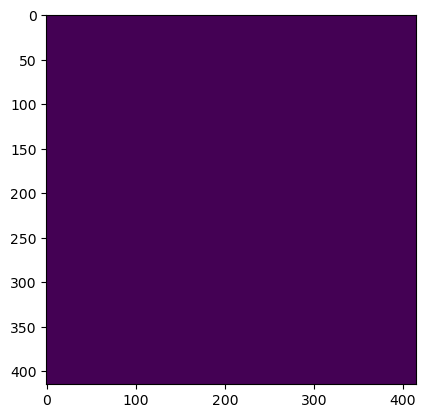

In [162]:
sqform_tensor = model.squareformer((x.unsqueeze(1) * x.unsqueeze(2)).transpose(1,3)).squeeze()
plt.imshow(sqform_tensor[0].detach().cpu().numpy())

## Test Runtime

In [7]:
all_pdb_chains = adl.dataset._get_keys()

In [8]:
from rocketshp.esm3 import (
    _get_model,
    _get_structure_vae,
    _get_tokenizers,
    embed,
)

device = torch.device("cuda:0")

struct_encoder, _ = _get_structure_vae()
struct_encoder = struct_encoder.eval().to(device)

esm_model = _get_model("esm3-open")
esm_model = esm_model.eval().to(device)

tokenizers = _get_tokenizers("esm3-open")
struct_tokenizer = tokenizers.structure

Fetching 22 files:   0%|          | 0/22 [00:00<?, ?it/s]

/home/ssledzieski/miniforge3/envs/torch/lib/python3.11/site-packages/esm/pretrained.py:29: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load(
/home/ssled

In [9]:
model = model.to(device)

In [10]:
[f.shape for f in feats.values()]

[torch.Size([183, 1536]), torch.Size([183]), torch.Size([183])]

In [11]:
import time
from esm.utils.structure.protein_chain import ProteinChain
from esm.utils.encoding import tokenize_structure

results = {}
precomputed_feats = {}

for pdb_id in tqdm(all_pdb_chains):
    pdb_file_path = config.RAW_DATA_DIR / f"atlas/{pdb_id[:2]}/{pdb_id}.pdb"
    esm_chain = ProteinChain.from_pdb(pdb_file_path)

    # Tokenize structure
    with torch.inference_mode():
        _, plddt, struct_tokens = tokenize_structure(
            torch.from_numpy(esm_chain.atom37_positions),
            structure_encoder=struct_encoder,
            structure_tokenizer=struct_tokenizer,
            reference_sequence=esm_chain.sequence,
        )

        # Embed sequence
        embeddings = embed([esm_chain.sequence], esm_model, tokenizers, device=device).squeeze()

        tmp_feats = {
            "seq_feats": embeddings.to("cpu"),
            "struct_feats": struct_tokens.to("cpu"),
            "temp": torch.tensor(300 * torch.ones_like(struct_tokens)).to("cpu")
        }
        precomputed_feats[pdb_id] = tmp_feats

  0%|          | 0/1389 [00:00<?, ?it/s]/home/ssledzieski/miniforge3/envs/torch/lib/python3.11/site-packages/esm/models/vqvae.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=False):  # type: ignore
/tmp/ipykernel_555188/1647324440.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "temp": torch.tensor(300 * torch.ones_like(struct_tokens)).to("cpu")
  0%|          | 1/1389 [00:00<07:46,  2.98it/s]/home/ssledzieski/miniforge3/envs/torch/lib/python3.11/site-packages/esm/models/vqvae.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=False):  # type: ignore
100%|██████

In [31]:
import time
from esm.utils.structure.protein_chain import ProteinChain
from esm.utils.encoding import tokenize_structure

results = {}

start_time = time.time()
for pdb_id in tqdm(all_pdb_chains):
    pdb_file_path = config.RAW_DATA_DIR / f"atlas/{pdb_id[:2]}/{pdb_id}.pdb"
    esm_chain = ProteinChain.from_pdb(pdb_file_path)

    # Tokenize structure
    with torch.inference_mode():
        _, plddt, struct_tokens = tokenize_structure(
            torch.from_numpy(esm_chain.atom37_positions),
            structure_encoder=struct_encoder,
            structure_tokenizer=struct_tokenizer,
            reference_sequence=esm_chain.sequence,
        )

        # Embed sequence
        embeddings = embed([esm_chain.sequence], esm_model, tokenizers, device=device).squeeze()

        tmp_feats = {
            "seq_feats": embeddings,
            "struct_feats": struct_tokens,
            "temp": torch.tensor(300 * torch.ones_like(struct_tokens))
        }
        both_result = model({k: v.to(device).unsqueeze(0) for k, v in feats.items()})

        results[pdb_id] = both_result

end_time = time.time()
logger.info(f"Time elapsed: {end_time - start_time:.2f} s")
logger.info(f"Time per sample: {(end_time - start_time) / len(all_pdb_chains):.2f} s")

  0%|          | 0/1389 [00:00<?, ?it/s]/home/ssledzieski/miniforge3/envs/torch/lib/python3.11/site-packages/esm/models/vqvae.py:289: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=False):  # type: ignore
/tmp/ipykernel_553152/3021995347.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "temp": torch.tensor(300 * torch.ones_like(struct_tokens))
100%|██████████| 1389/1389 [03:35<00:00,  6.46it/s]

2025-01-14 15:35:43.302 | INFO     | __main__:<module>:34 - Time elapsed: 215.14 s
2025-01-14 15:35:43.302 | INFO     | __main__:<module>:35 - Time per sample: 0.15 s
